In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Implementing Activation Patching hook

In [ ]:
import torch
import torch.nn as nn
import transformers
import math
from transformers import ViTImageProcessor, ViTForImageClassification, AutoConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

class Activation_Patch:
  def __init__(self):
    self.activations = {}
    self.activations['attention_heads'] = []

  def __call__(self, patch_head, patch_activation, module, module_in, module_out):
    self.activations['input'] = (module_in)
    self.activations['output'] = (module_out)
    self.activations['key'] = module.key
    self.activations['query'] = module.query

    def transpose_for_scores(x: torch.Tensor) -> torch.Tensor:
      new_x_shape = x.size()[:-1] + (12, 64)
      x = x.view(new_x_shape)
      return x.permute(0, 2, 1, 3)

    key_activations = transpose_for_scores(module.key(module_in[0]))
    query_activations = transpose_for_scores(module.query(module_in[0]))
    value_activations = transpose_for_scores(module.value(module_in[0]))

    attention_scores = torch.matmul(query_activations, key_activations.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(64)
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)

    if isinstance(patch_activation, torch.Tensor):
      attention_probs[:,patch_head,:,:] = patch_activation
      self.activations['patching_done'] = True
    else:
      self.activations['patching_done'] = False
      
    self.activations['attention_heads'].append(attention_probs)

    # Mask heads if we want to
    if module_in[1] is not None:
        attention_probs = attention_probs * module_in[1]

    context_layer = torch.matmul(attention_probs, value_activations)

    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    new_context_layer_shape = context_layer.size()[:-2] + (12*64,)
    context_layer = context_layer.view(new_context_layer_shape)

    outputs = (context_layer, attention_probs) if module_in[2] else (context_layer,)

    return outputs

  def clear(self):
    self.activations = {}

In [ ]:
from functools import partial
patch = Activation_Patch()

for module in model.modules():
  if isinstance(module, transformers.models.vit.modeling_vit.ViTSelfAttention):
    module.register_forward_hook(partial(patch, False, False))

In [ ]:
from torchvision.io import read_image

dog_img = read_image('/content/n02099712_Labrador_retriever.jpg')
process = ViTImageProcessor()

dog_img = process(dog_img, return_tensors='pt')['pixel_values']

with torch.no_grad():
    dog_logits = model(dog_img)

In [ ]:
dog_activation_heads = patch.activations['attention_heads']
patch.clear()

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

cat_img = read_image('/content/n02123394_Persian_cat.jpg')
process = ViTImageProcessor()

cat_img = process(cat_img, return_tensors='pt')['pixel_values']

patch = Activation_Patch()

for module in model.modules():
  if isinstance(module, transformers.models.vit.modeling_vit.ViTSelfAttention):
    module.register_forward_hook(partial(patch, False, False))

with torch.no_grad():
    cat_logits = model(cat_img)

In [ ]:
cat_activation_heads = patch.activations['attention_heads']
patch.clear()

## Patching dog input towards cat logit

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

cat_img = read_image('/content/n02123394_Persian_cat.jpg')
process = ViTImageProcessor()

cat_img = process(cat_img, return_tensors='pt')['pixel_values']

patch = Activation_Patch()

layer = 0
head = 0

for name, module in model.named_modules():
  if f'layer.{layer}' in name and isinstance(module, transformers.models.vit.modeling_vit.ViTSelfAttention):
    module.register_forward_hook(partial(patch, head, cat_activation_heads[layer][:,head,:,:]))

with torch.no_grad():
    patched_logits = model(dog_img)

In [ ]:
print(patch.activations['attention_heads'][0].shape)
patch.clear()

torch.Size([1, 12, 197, 197])


### Turning it into a loop: Layer 0, All heads

In [ ]:
patched_logits = []
head_names = []
for head in range(12):
  layer = 0
  patch = Activation_Patch()
  head_names.append(f'L{layer}H{head}')
  
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

  for name, module in model.named_modules():
    if f'layer.{layer}' in name and isinstance(module, transformers.models.vit.modeling_vit.ViTSelfAttention):
      module.register_forward_hook(partial(patch, head, cat_activation_heads[layer][:,head,:,:]))

  with torch.no_grad():
    scores = model(dog_img)
    patched_logits.append(scores.logits)

  patch.clear()

In [ ]:
metrics = []

for i in range(len(patched_logits)):
  clean_logit_diff = cat_logits.logits[0,283].item() - cat_logits.logits[0,208].item()
  corrupted_logit_diff = dog_logits.logits[0,283].item() - dog_logits.logits[0,208].item()
  patched_logit_diff = patched_logits[i][0,283].item() - patched_logits[i][0,208].item()
  metrics.append((patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff  - corrupted_logit_diff))

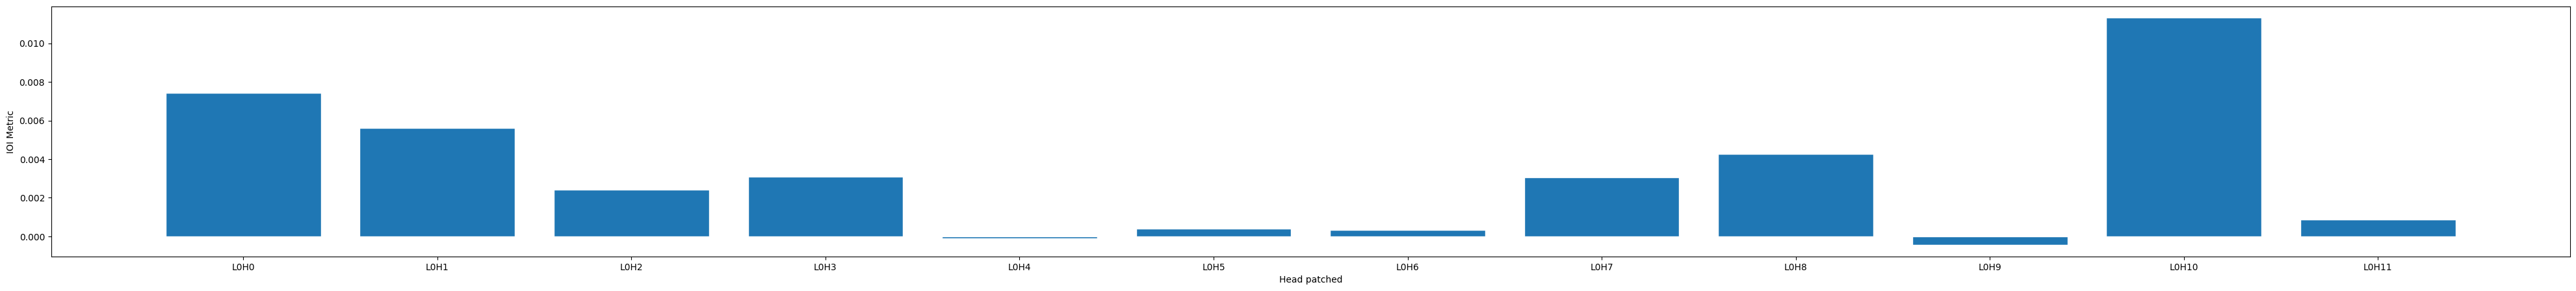

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(50, 5))

sns.set_theme()
ax.bar(head_names, metrics)

plt.xlabel('Head patched')
plt.ylabel('IOI Metric')

plt.show()

## All layers, all heads

In [ ]:
patched_logits_layer = []
head_names = []
for layer in range(12):
  patched_logits_head = []
  for head in range(12):
    patch = Activation_Patch()
    head_names.append(f'L{layer}H{head}')
    
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

    for name, module in model.named_modules():
      if f'layer.{layer}' in name and isinstance(module, transformers.models.vit.modeling_vit.ViTSelfAttention):
        module.register_forward_hook(partial(patch, head, cat_activation_heads[layer][:,head,:,:]))

    with torch.no_grad():
      scores = model(dog_img)
      patched_logits_head.append(scores.logits)
    
    patch.clear()

  patched_logits_layer.append(patched_logits_head)

In [ ]:
print(len(patched_logits_layer), len(patched_logits_layer[0]))

12 12


In [ ]:
metrics_layers = []

for j in range(len(patched_logits_layer)):
  metrics_heads = []
  for i in range(len(patched_logits_layer[j])):
    clean_logit_diff = cat_logits.logits[0,283].item() - cat_logits.logits[0,208].item()
    corrupted_logit_diff = dog_logits.logits[0,283].item() - dog_logits.logits[0,208].item()
    patched_logit_diff = patched_logits_layer[j][i][0,283].item() - patched_logits_layer[j][i][0,208].item()
    metrics_heads.append((patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff  - corrupted_logit_diff))
  metrics_layers.append(metrics_heads)

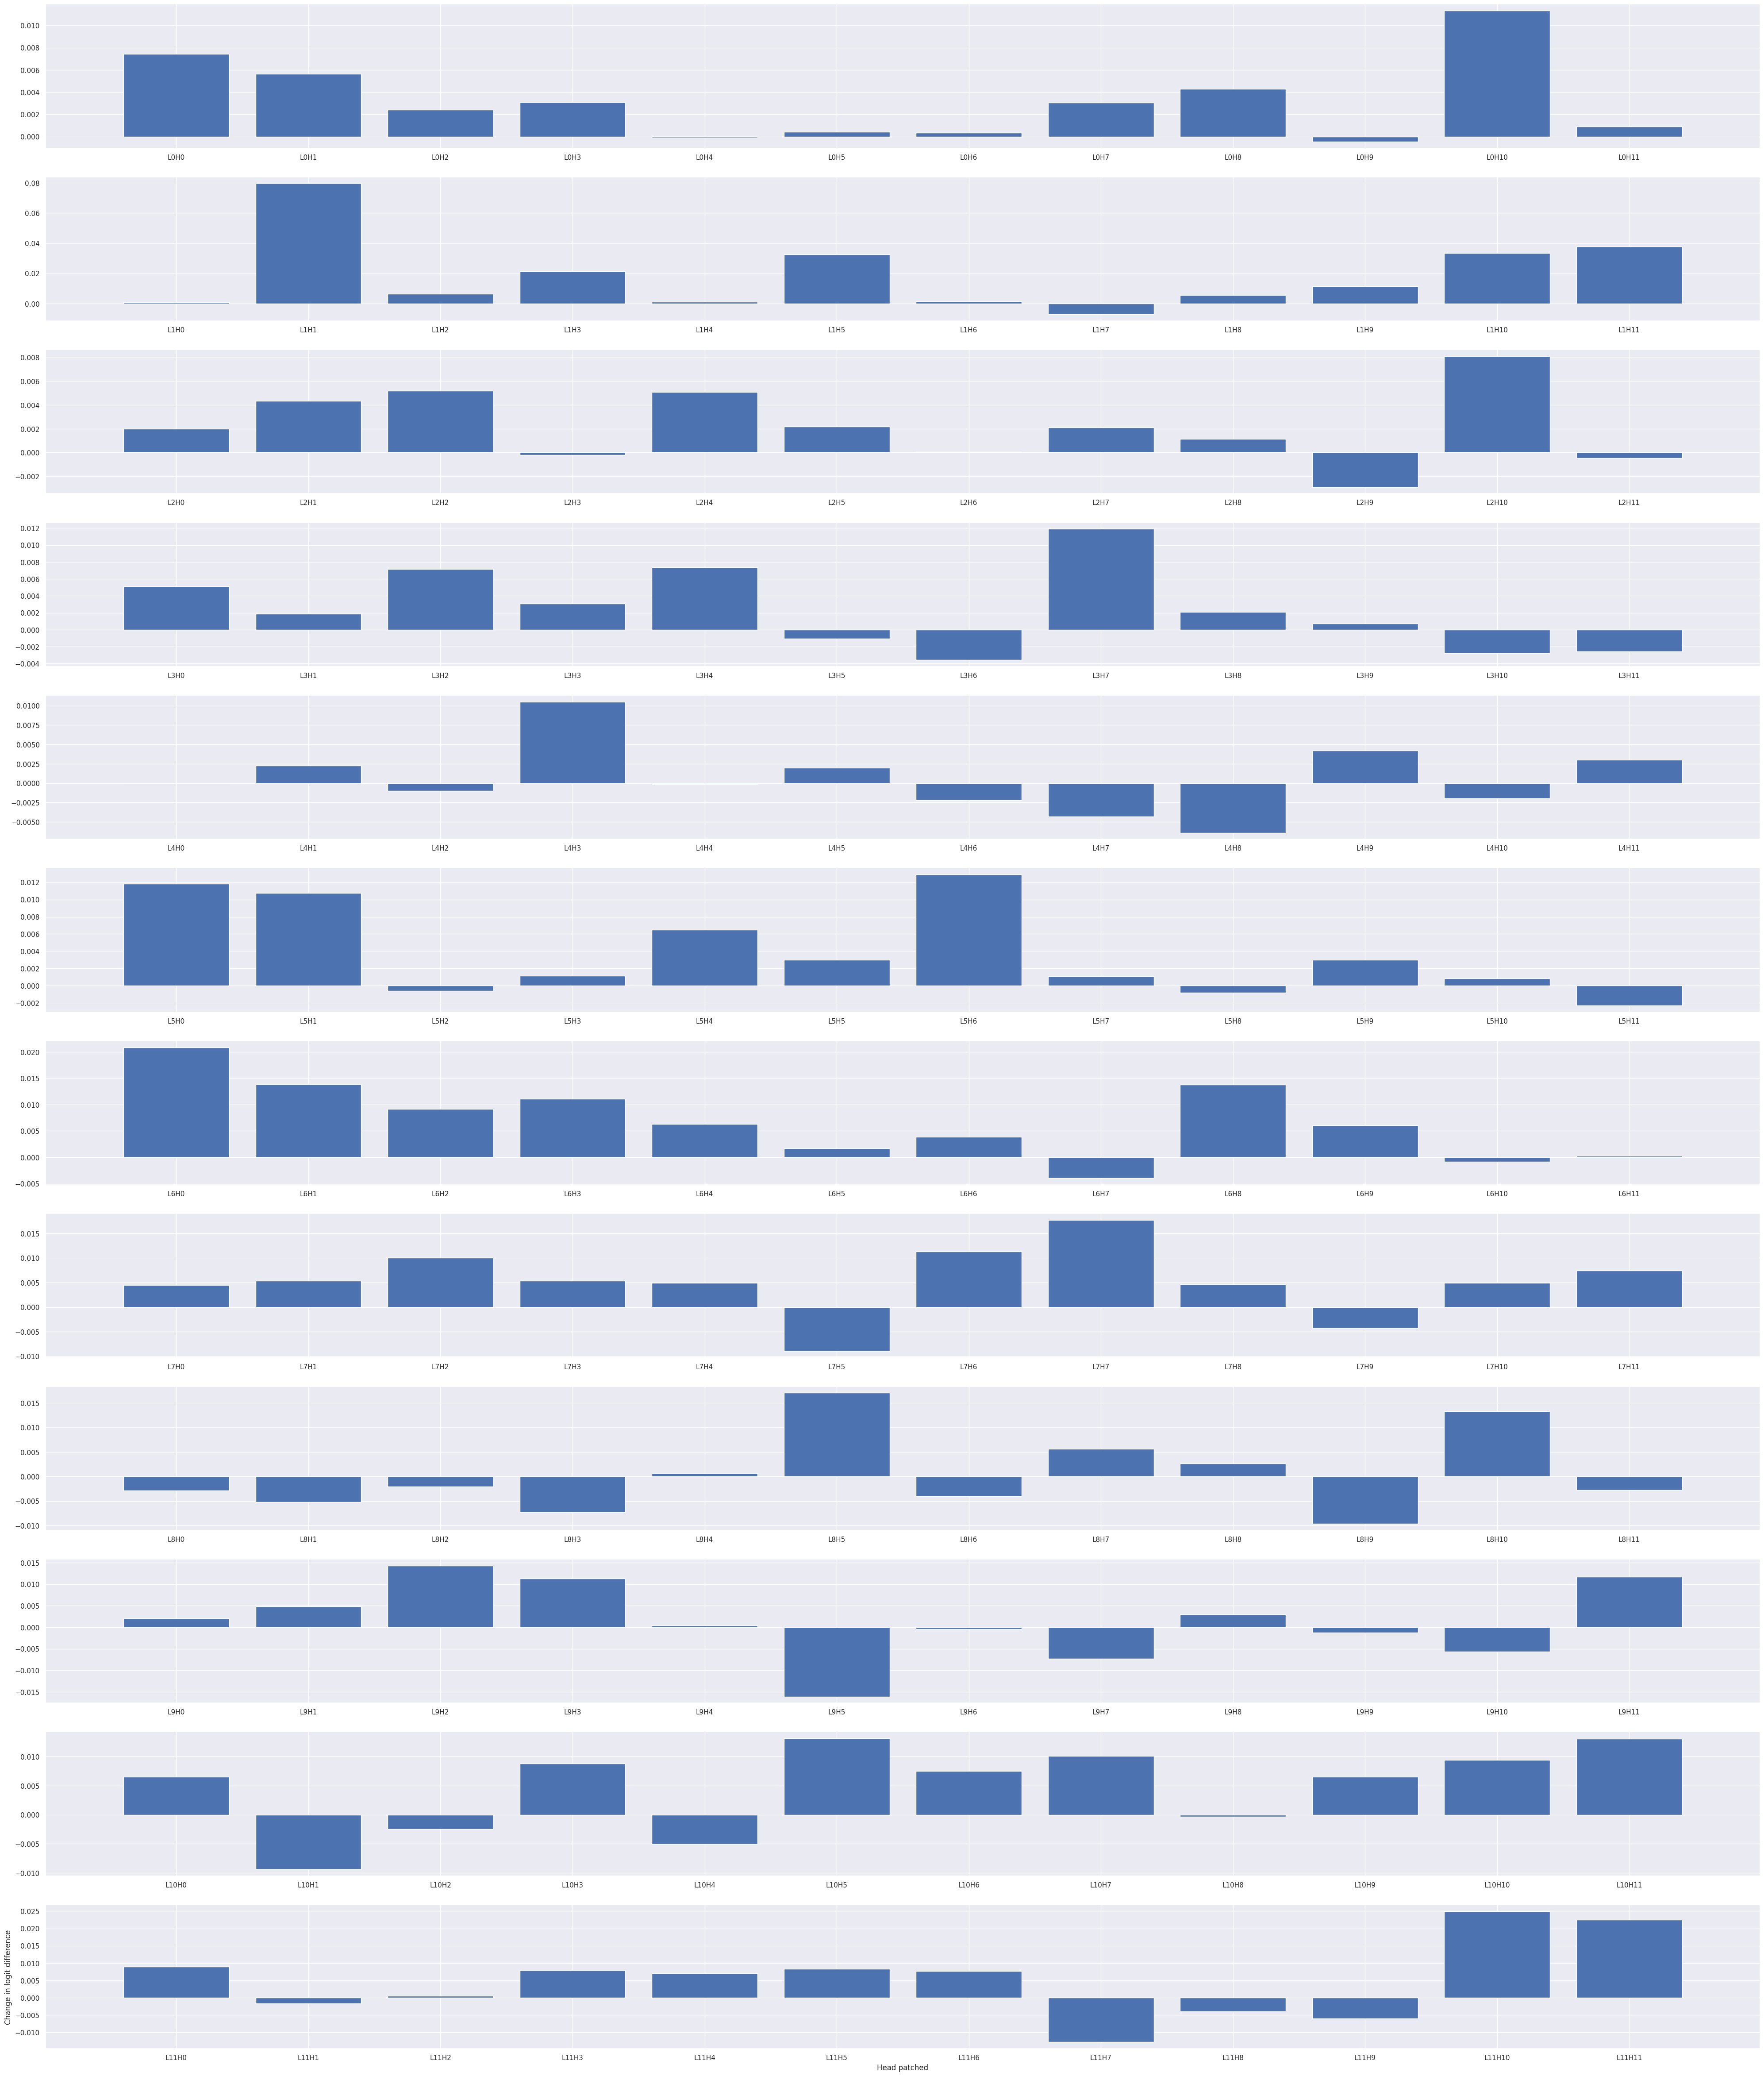

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(12,1, figsize=(50, 60))

sns.set_theme()

for i in range(len(metrics_layers)):
  ax[i].bar(head_names[i*12:i*12+12], metrics_layers[i])

plt.xlabel('Head patched')
plt.ylabel('Change in logit difference')

plt.show()

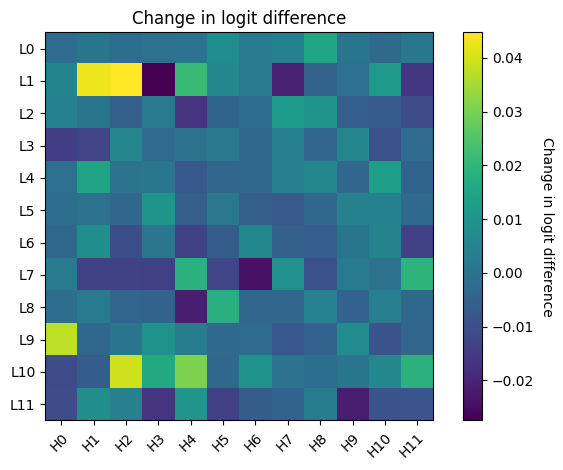

In [ ]:
import numpy as np
sns.reset_orig()
layers = [f'L{i}' for i in range(12)]
heads = [f'H{i}' for i in range(12)]

change_in_logit_difference = np.asarray(metrics_layers)

fig, ax = plt.subplots()
im = ax.imshow(change_in_logit_difference)

ax.set_yticks(np.arange(len(layers)), labels=layers)
ax.set_xticks(np.arange(len(heads)), labels=heads)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ticks = [-0.02, -0.01, 0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])
cbar.ax.set_ylabel('Change in logit difference', rotation=-90, va="bottom")

ax.set_title("Change in logit difference")
fig.tight_layout()

plt.show()

## Patching: Cat vs Modem

In [ ]:
from torchvision.io import read_image
from functools import partial
patch = Activation_Patch()

model =  ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()
for module in model.modules():
  if isinstance(module, transformers.models.vit.modeling_vit.ViTSelfAttention):
    module.register_forward_hook(partial(patch, False, False))

modem_img = read_image('/content/n03777754_modem.JPEG')

process = ViTImageProcessor()

modem_img = process(modem_img, return_tensors='pt')['pixel_values']

with torch.no_grad():
    modem_logits = model(modem_img)

In [ ]:
modem_activation_heads = patch.activations['attention_heads']
patch.clear()

In [ ]:
patched_logits_layer = []
head_names = []
for layer in range(12):
  patched_logits_head = []
  for head in range(12):
    patch = Activation_Patch()
    head_names.append(f'L{layer}H{head}')
    
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

    for name, module in model.named_modules():
      if f'layer.{layer}' in name and isinstance(module, transformers.models.vit.modeling_vit.ViTSelfAttention):
        module.register_forward_hook(partial(patch, head, cat_activation_heads[layer][:,head,:,:]))

    with torch.no_grad():
      scores = model(modem_img)
      patched_logits_head.append(scores.logits)
    
    patch.clear()

  patched_logits_layer.append(patched_logits_head)

In [ ]:
metrics_layers = []

for j in range(len(patched_logits_layer)):
  metrics_heads = []
  for i in range(len(patched_logits_layer[j])):
    clean_logit_diff = cat_logits.logits[0,283].item() - cat_logits.logits[0,208].item()
    corrupted_logit_diff = modem_logits.logits[0,283].item() - modem_logits.logits[0,208].item()
    patched_logit_diff = patched_logits_layer[j][i][0,283].item() - patched_logits_layer[j][i][0,208].item()
    metrics_heads.append((patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff  - corrupted_logit_diff))
  metrics_layers.append(metrics_heads)

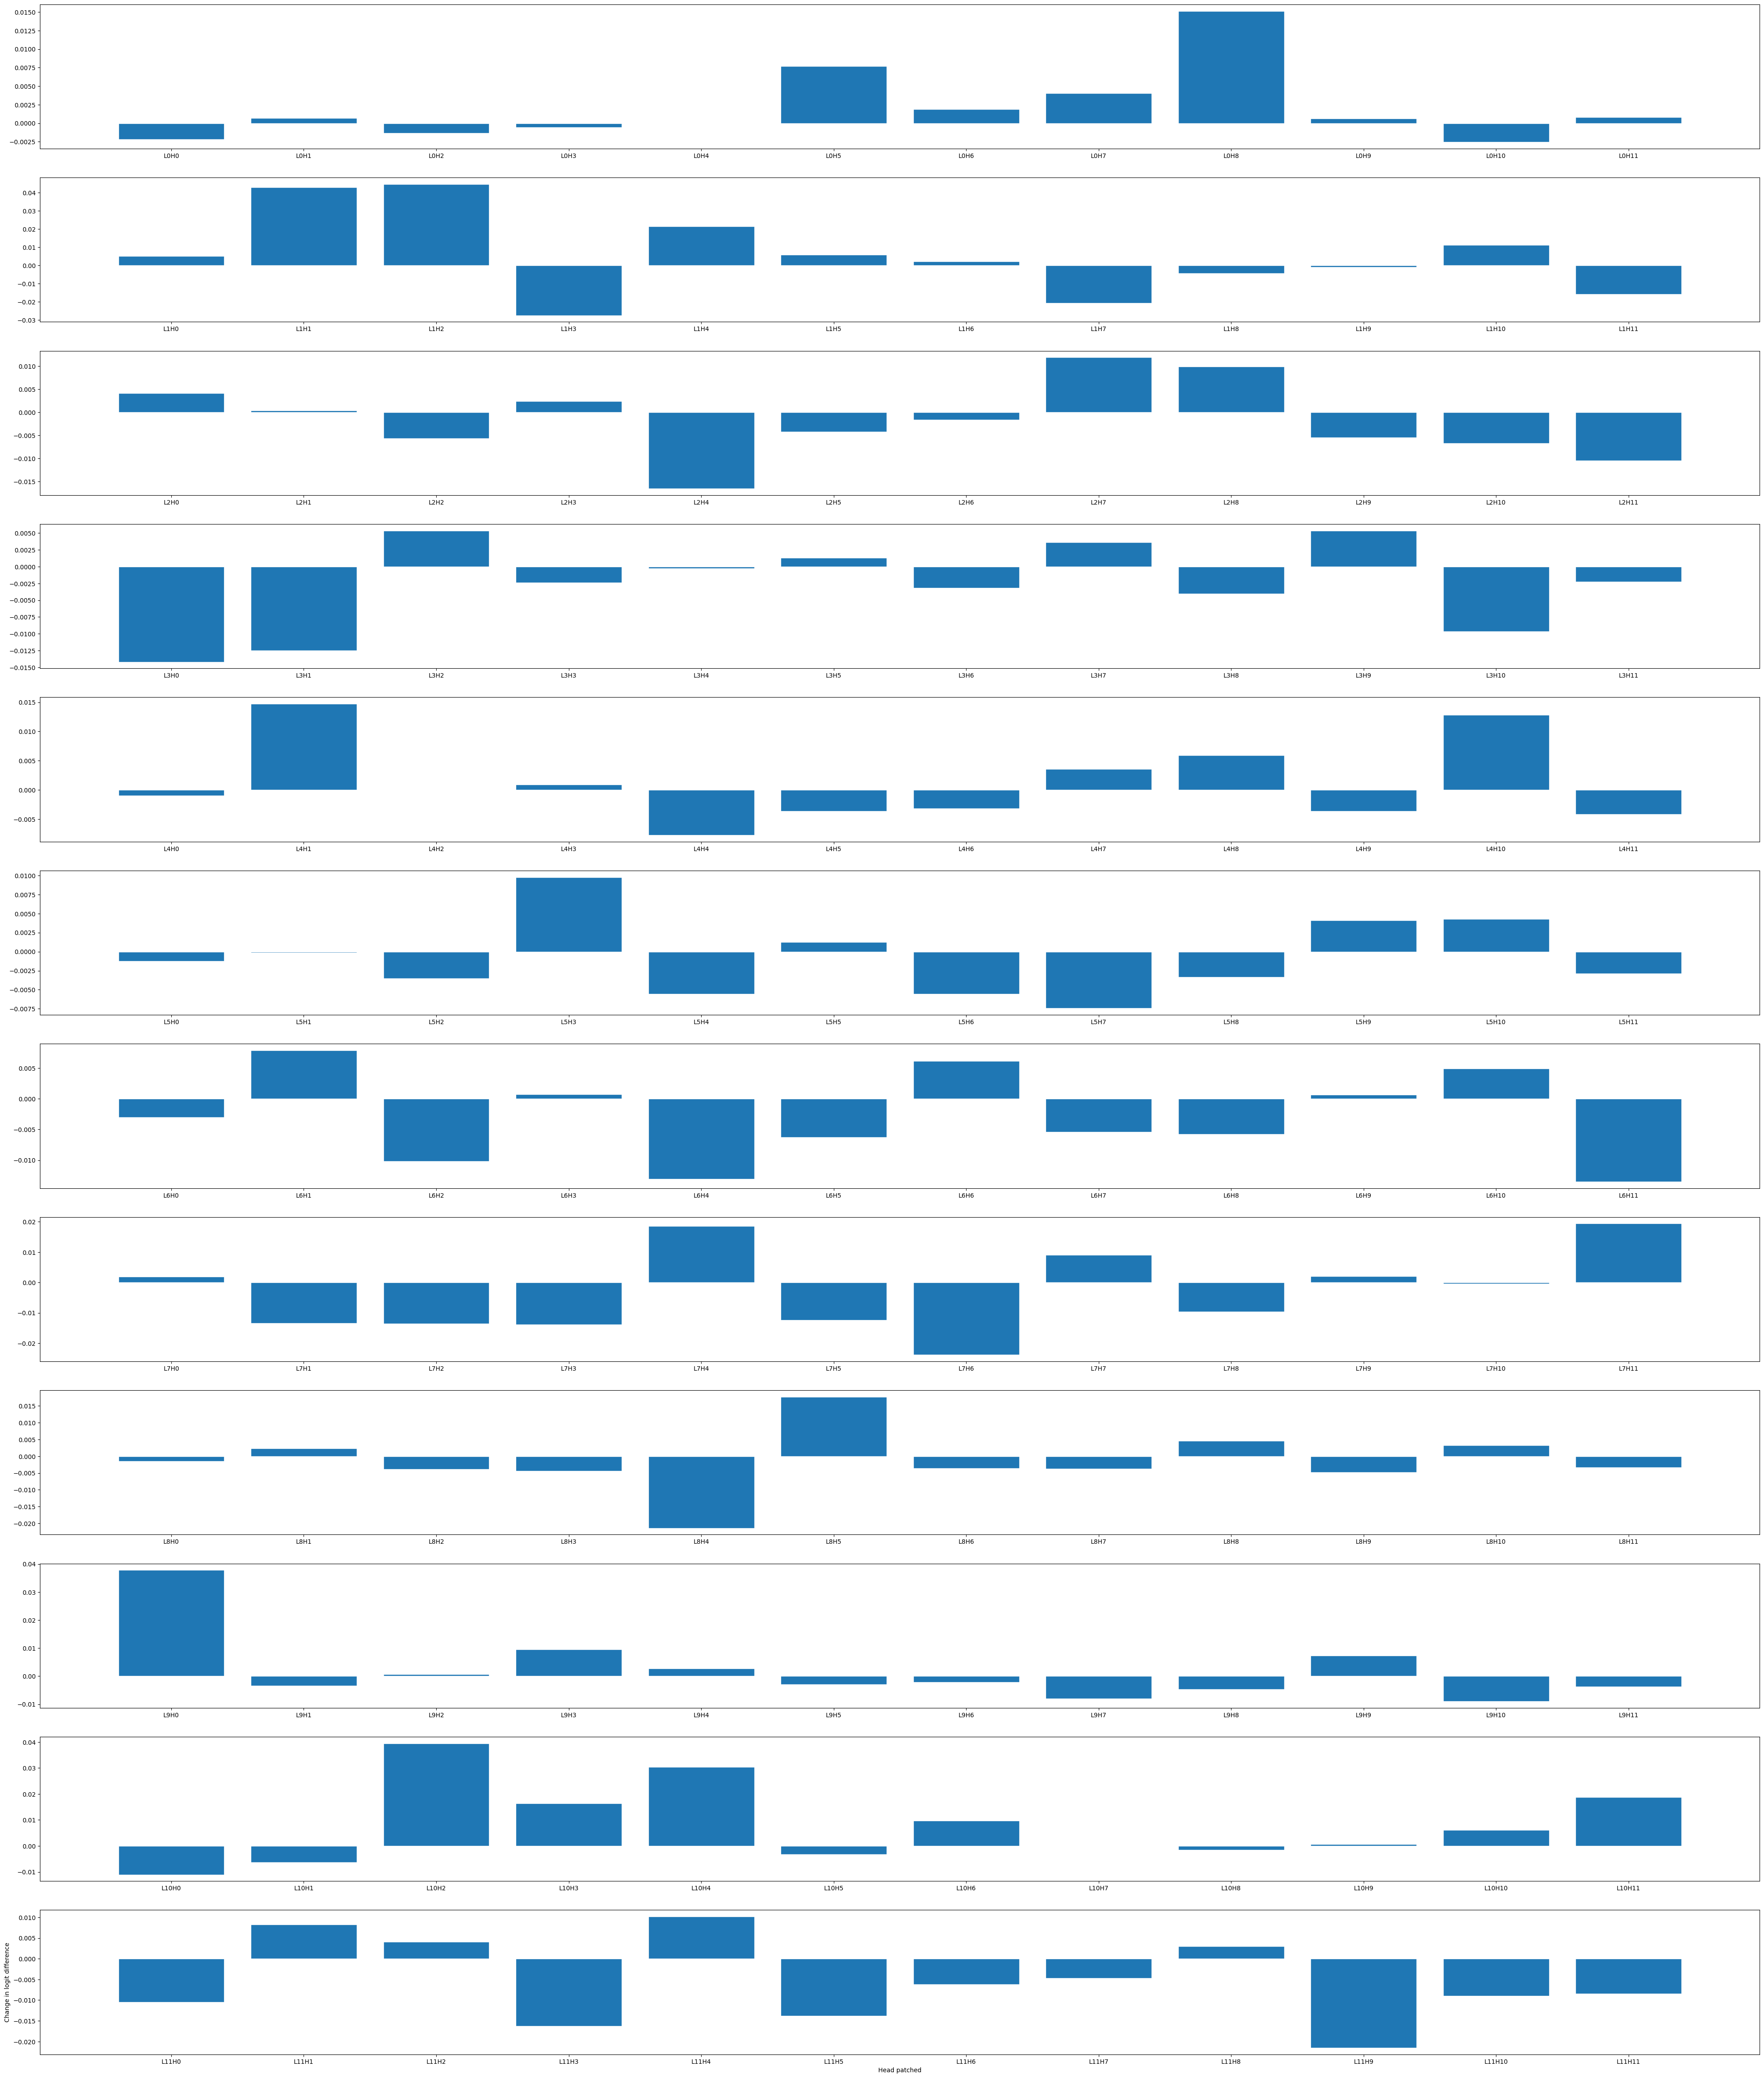

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(12,1, figsize=(50, 60))

sns.set_theme()

for i in range(len(metrics_layers)):
  ax[i].bar(head_names[i*12:i*12+12], metrics_layers[i])

plt.xlabel('Head patched')
plt.ylabel('Change in logit difference')

plt.show()

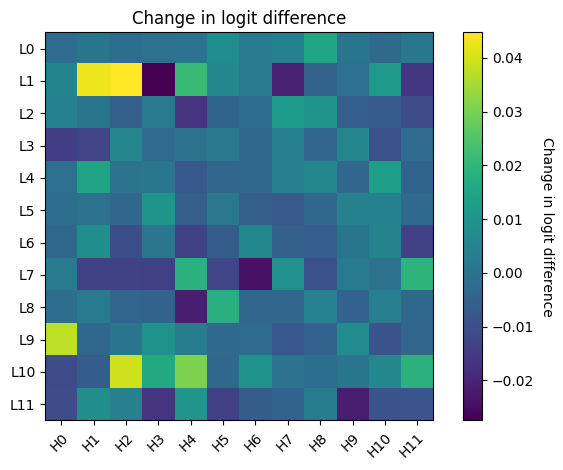

In [ ]:
import numpy as np
sns.reset_orig()
layers = [f'L{i}' for i in range(12)]
heads = [f'H{i}' for i in range(12)]

change_in_logit_difference = np.asarray(metrics_layers)

fig, ax = plt.subplots()
im = ax.imshow(change_in_logit_difference)

ax.set_yticks(np.arange(len(layers)), labels=layers)
ax.set_xticks(np.arange(len(heads)), labels=heads)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ticks = [-0.02, -0.01, 0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])
cbar.ax.set_ylabel('Change in logit difference', rotation=-90, va="bottom")

ax.set_title("Change in logit difference")
fig.tight_layout()

plt.show()

## Patching top 5 heads that exhibit positive change in logit difference

In [ ]:
cild = torch.from_numpy(change_in_logit_difference)
v, i = torch.topk(cild.flatten(), 5)

layer_heads = np.sort(np.array(np.unravel_index(i.numpy(), cild.shape)).T, axis=0)
print(layer_heads)

[[ 1  0]
 [ 1  1]
 [ 9  2]
 [10  2]
 [10  4]]


In [ ]:
layer_heads.shape[0]

5

In [ ]:
patched_logits = []
head_names = []

patch = Activation_Patch()
head_names.append(f'L{layer}H{head}')

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()
i = 0
while i < layer_heads.shape[0]:
  layer, head = layer_heads[i]
  for name, module in model.named_modules():
    if f'layer.{layer}' in name and isinstance(module, transformers.models.vit.modeling_vit.ViTSelfAttention):
      module.register_forward_hook(partial(patch, head, cat_activation_heads[layer][:,head,:,:]))
      i += 1
      break

with torch.no_grad():
  scores = model(dog_img)
  patched_logits.append(scores.logits)

patch.clear()

0
1
2
3
4


In [ ]:
clean_logit_diff = cat_logits.logits[0,283].item() - cat_logits.logits[0,208].item()
corrupted_logit_diff = modem_logits.logits[0,283].item() - modem_logits.logits[0,208].item()
patched_logit_diff = patched_logits[0][0,283].item() - patched_logits[0][0,208].item()

print((patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff  - corrupted_logit_diff))

-1.009570652208064


## Patching MLPs

In [ ]:
import torch
import torch.nn as nn
import transformers
import math
import collections
from transformers import ViTImageProcessor, ViTForImageClassification, AutoConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

cat_activations = collections.defaultdict(list)
handles = []

def save_activation(activations, name, mod, inp, out):
  activations[name].append(out)
   
for n, m in model.named_modules():
  handle = m.register_forward_hook(partial(save_activation, cat_activations, n))
  handles.append(handle)

dog_img = read_image('/content/n02099712_Labrador_retriever.jpg')
process = ViTImageProcessor()

dog_img = process(dog_img, return_tensors='pt')['pixel_values']

with torch.no_grad():
    dog_logits = model(dog_img)


In [ ]:
cat_activations['vit'][0][0][:,0,:].shape

torch.Size([1, 768])

In [ ]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7